# Quick intro

## This notebook is extending (and changing a lot) of my [notebook-walkthrough for quantile regression with LR-Schedulers and model-checkpoints](https://www.kaggle.com/chrisden/6-82-quantile-reg-lr-schedulers-checkpoints).  
## The goal of this Notebook is to introduce several methods for hyperparameter-optimization backed with cross-validation. For this goal, a lot of code the orginial code will be hidden (of course you can open it) and shortcutted to enhance readbility.



## Update history:
V30: Final version  
V25: Improvements in logging & ensembling  
V20: Enhanced logging, ENSEMBLING!  
V16: Several improvements, getting better results now!
V10: Introduced usage of tensorflow.addons (tfa): WeightNormalization  
V7&8: Added support for maximizing cv-score or minimizing val_loss; added TODOS  
V6: Fixed an important bug: Hyperparameter search should MAXIMIZE score (was set to MINIMIZE due to copy paste)  
V5: Formatting, correcting typos.  
V2,3,4: Fast consequitive runs for fixing minor bugs, formatting, correcting typos.  
V1: Initial commit


## Domain knowledge

### Some domain knowledge can be gained from watching the following video and from reading [here.](https://www.kaggle.com/c/osic-pulmonary-fibrosis-progression/discussion/165727)

In [ ]:
from IPython.display import HTML
HTML('<center><iframe width="560" height="315" src="https://www.youtube.com/embed/AfK9LPNj-Zo" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe></center>')

## Load all dependencies you need
<span style="color:darkgreen ;font-family: Impact; font-size:13;"> from  </span> coffee  <span style="color:darkgreen ;font-family: Impact; font-size:13;"> import  </span> ***** 

In [ ]:
import numpy as np
import random
import pandas as pd
import pydicom
import os
import matplotlib.pyplot as plt
from timeit import timeit
from tqdm import tqdm
from PIL import Image

from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold, GroupKFold, StratifiedKFold

#color
from colorama import Fore, Back, Style

import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow.keras.layers as Layers
import warnings
warnings.filterwarnings('ignore') #Ignore "future" warnings and Data-Frame-Slicing warnings.


In [ ]:
def seed_everything(seed): 
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
seed_everything(2000)

# First glimpse at the data

In [ ]:
ROOT = '../input/osic-pulmonary-fibrosis-progression'

train_df = pd.read_csv(f'{ROOT}/train.csv')
print(f'Train data has {train_df.shape[0]} rows and {train_df.shape[1]} columnns and looks like this:')


In [ ]:
train_df.sample(5)

# Data Wrangling

In [ ]:
train_unique_df = train_df.drop_duplicates(subset = ['Patient'], keep = 'first')
#train_unique_df.head()

In [ ]:
# CHECK FOR DUPLICATES & DEAL WITH THEM
# keep = False: All duplicates will be shown
dupRows_df = train_df[train_df.duplicated(subset = ['Patient', 'Weeks'], keep = False )]
# dupRows_df.head()

In [ ]:
train_df.drop_duplicates(subset=['Patient','Weeks'], keep = False, inplace = True)

In [ ]:
print(f'So there are {dupRows_df.shape[0]} (= {dupRows_df.shape[0] / train_df.shape[0] * 100:.2f}%) duplicates.')

In [ ]:
test_df = pd.read_csv(f'{ROOT}/test.csv')
print(f'Test data has {test_df.shape[0]} rows and {test_df.shape[1]} columnns, has no duplicates and looks like this:')
test_df.head()

## Getting the format right

In this section we are going to do all the Data-Wrangling and pre-processing. For this we are going to define some functions and transformations, which then are applied to the data.
It's good practice to concatinate all tabular data (train, test, submission), to ensure all data get's the same & correct treatment.
If you don't do that, you need to be careful with some steps, e.g.: 
* Standardization or Normalization (e.g. MinMax Scaling) in ```test_df``` will not have the same range of values (e.g. min/max values) and therefore scaling than in ```train_df```.
* The categorical features might have different categories in ```test_df``` than in ```train_df``` (e.g. ```test_df``` only contains male, Ex-smokers).

So let's concatinate all our data first and then start with the transformations.
### The functions for this are hidden, as the focus for this notebook is the RandomCV hyperparameter optimization.

In [ ]:
## CHECK SUBMISSION FORMAT
sub_df = pd.read_csv(f"{ROOT}/sample_submission.csv")

print(f"The sample submission contains: {sub_df.shape[0]} rows and {sub_df.shape[1]} columns.")

In [ ]:
# sub_df.head()

In [ ]:
# split Patient_Week Column and re-arrage columns
sub_df[['Patient','Weeks']] = sub_df.Patient_Week.str.split("_",expand = True)
sub_df =  sub_df[['Patient','Weeks','Confidence', 'Patient_Week']]

In [ ]:
sub_df = sub_df.merge(test_df.drop('Weeks', axis = 1), on = "Patient")

In [ ]:
# introduce a column to indicate the source (train/test) for the data
train_df['Source'] = 'train'
sub_df['Source'] = 'test'

data_df = train_df.append([sub_df])
data_df.reset_index(inplace = True)
#data_df.head()

In [ ]:
def get_baseline_week(df):
    # make a copy to not change original df    
    _df = df.copy()
    # ensure all Weeks values are INT and not accidentaly saved as string
    _df['Weeks'] = _df['Weeks'].astype(int)
    # as test data is containing all weeks, 
    _df.loc[_df.Source == 'test','min_week'] = np.nan
    _df["min_week"] = _df.groupby('Patient')['Weeks'].transform('min')
    _df['baselined_week'] = _df['Weeks'] - _df['min_week']
    
    return _df   

In [ ]:
data_df = get_baseline_week(data_df)
#data_df.head()

In [ ]:
def get_baseline_FVC_old(df):
    # copy the DF to not in-place change the original one
    _df = df.copy()
    # get only the rows containing the baseline (= min_weeks) and therefore the baseline FVC
    baseline = _df.loc[_df.Weeks == _df.min_week]
    baseline = baseline[['Patient','FVC']].copy()
    baseline.columns = ['Patient','base_FVC']      
    
    # fill the df with the baseline FVC values
    for idx in _df.index:
        patient_id = _df.at[idx,'Patient']
        _df.at[idx,'base_FVC'] = baseline.loc[baseline.Patient == patient_id, 'base_FVC'].iloc[0]
    _df.drop(['min_week'], axis = 1)
    
    return _df

In [ ]:
def get_baseline_FVC(df):
    # same as above
    _df = df.copy()
    base = _df.loc[_df.Weeks == _df.min_week]
    base = base[['Patient','FVC']].copy()
    base.columns = ['Patient','base_FVC']
    
    # add a row which contains the cumulated sum of rows for each patient
    base['nb'] = 1
    base['nb'] = base.groupby('Patient')['nb'].transform('cumsum')
    
    # drop all except the first row for each patient (= unique rows!), containing the min_week
    base = base[base.nb == 1]
    base.drop('nb', axis = 1, inplace = True)
    
    # merge the rows containing the base_FVC on the original _df
    _df = _df.merge(base, on = 'Patient', how = 'left')    
    _df.drop(['min_week'], axis = 1)
    
    return _df

In [ ]:
def old_baseline_FVC():
    return get_baseline_FVC_old(data_df)
    pass

def new_baseline_FVC():
    return get_baseline_FVC(data_df)
    

duration_old = timeit(old_baseline_FVC, number = 3)
duration_new = timeit(new_baseline_FVC, number = 3)

#print(f"Taking the old, non-vectorized version took {duration_old / 3:.2f} sec, while the vectorized version only took {duration_new / 3:.3f} sec. That's {duration_old/duration_new:.0f} times faster!" )

In [ ]:
data_df = get_baseline_FVC(data_df)
data_df.head()

Now the data has the format we need to work with.
In the next section, we go trough two possibilities on how to normalize, standardize and prepare the data for the neural Network.

## Preparing the data for the Neural Network

### Let's do the Data-Prep and all related legwork ourselfs, w/o sklearn. How to use sklearn, you can read here: 
https://www.kaggle.com/chrisden/6-82-quantile-reg-lr-schedulers-checkpoints  

The good thing is: we dont need a NoTransformer here, as we simply can work in the DataFrame itself and not change any data which we want to preserve.
Downside is, we need to implement the MinMaxScaler by hand. Make sure to not call it MinMaxScaler and shadow the already important MinMaxScaler from Sklearn!


In [ ]:
def own_MinMaxColumnScaler(df, columns):
    """Adds columns with scaled numeric values to range [0, 1]
    using the formula X_scld = (X - X.min) / (X.max - X.min)"""
    for col in columns:
        new_col_name = col + '_scld'
        col_min = df[col].min()
        col_max = df[col].max()        
        df[new_col_name] = (df[col] - col_min) / ( col_max - col_min )

In [ ]:
def own_OneHotColumnCreator(df, columns):
    """OneHot Encodes categorical features. Adds a column for each unique value per column"""
    for col in cat_attribs:
        for value in df[col].unique():
            df[value] = (df[col] == value).astype(int)

In [ ]:
## APPLY DEFINED TRANSFORMATIONS
# define which attributes shall not be transformed, are numeric or categorical
no_transform_attribs = ['Patient', 'Weeks', 'min_week']
num_attribs = ['FVC', 'Percent', 'Age', 'baselined_week', 'base_FVC']
cat_attribs = ['Sex', 'SmokingStatus']

own_MinMaxColumnScaler(data_df, num_attribs)
own_OneHotColumnCreator(data_df, cat_attribs)

data_df[data_df.Source != "train"].head()

In [ ]:
# get back original data split
train_df = data_df.loc[data_df.Source == 'train']
sub = data_df.loc[data_df.Source == 'test']

# Model & Loss
In this section we are going to define the loss & a first model.
First we are taking care of the loss. We are trying to minimize the following:

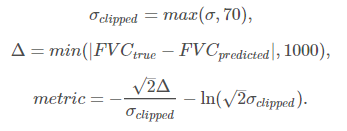

The global minimum of this function is achieved for delta = 0 and sigma = 70, which [results in a loss of roughly -4.59.](https://www.kaggle.com/c/osic-pulmonary-fibrosis-progression/discussion/168469).

Getting our model to predict the Confidence and FVC values (which is what we need!) is not working fine so far, as you can read [here](https://www.kaggle.com/c/osic-pulmonary-fibrosis-progression/discussion/167764).
Currently the way to go seems to be pinball loss. 


# <font color='blue'>CONFIG Section </font>

In this section you can configure the following:
* Features used for training
* Basic training setup: BATCH_SIZE and EPOCHS,
* Configuration for the loss function
* Optimizers, Learning-Rate-Schedulers incl. Learning Rate start- & endpoint
* Custom Logging Callback
* Checkpoint-Saving Callback

The Learning-Rate scheduler below is inspired by Chris great [Melanoma-detection notebook](https://www.kaggle.com/cdeotte/triple-stratified-kfold-with-tfrecords).  
Feel free to experiment with the scheduler and it's max/min and decay values.

**Ever wondered why lr_max is scaled by BATCH_SIZE and therefore bigger for larger batches?** The reason for this is the following: the larger the BATCH_SIZE, the more averaged & smoothened a step of gradient decent is and the bigger our confidence in the *direction* of the step is. As there is less "randomness" in a huge averaged batch (compared with for example Stochastic Gradient Decent (=SGD) with batch size = 1) and our confidence in the direction is higher, the learning rate can be bigger to advance fast to the optimum.

In [ ]:
######## BASIC CONFIG --- THIS IS GOING TO BE OVERWRITTEN BY OUR PARAMETER SEARCH BELOW ########
#the purpose of this section is to set a base-model and initialize all values. The (random)-Grid search is going to overwrite many of those values.
# be careful, the resulsts are VERY SEED-DEPENDEND!
seed_everything(1949)


### Features: choose which features you want to use
features_list = ['baselined_week_scld', 'Percent_scld', 'Age_scld', 'base_FVC_scld', 'Male', 'Female', 'Ex-smoker', 'Never smoked', 'Currently smokes']

### Basics for training:
NFOLDS = 5
EPOCHS = 1000
BATCH_SIZE = 96


### LOSS; set tradeoff btw. Pinball-loss and adding score
_lambda = 0.8 # 0.8 default


### Optimizers
# choose ADAM or SGD
optimizer = 'ADAM'

### Learning Rate Scheduler
def get_lr_callback(BATCH_SIZE = 64,
                    lr_start   = 0.000001,
                    lr_max     = 0.00001,
                    lr_min     = 0.000001,
                    lr_ramp_percent =  0.3,
                    plot = False):
    """Returns a lr_scheduler callback which is used for training.
    Feel free to change the values below!
    """
    lr_start   = lr_start
    lr_max     = lr_max * BATCH_SIZE # higher batch size --> higher lr
    lr_min     = lr_min
    # lr_ramp_percent defines which percentage of all epochs are used for ramping up the LR to the max
    lr_ramp_ep = EPOCHS * lr_ramp_percent
    lr_sus_ep  = 0
    lr_decay   = 0.991

    def lr_scheduler(epoch):
            if epoch < lr_ramp_ep:
                lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start

            elif epoch < lr_ramp_ep + lr_sus_ep:
                lr = lr_max

            else:
                lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min

            return lr
    
    if plot == False:
        # get the Keras-required callback with our LR for training
        lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler,verbose = False)
        return lr_callback 
    
    else: 
        return lr_scheduler
    
# plot & check the LR-Scheulder for sanity-check
lr_scheduler_plot = get_lr_callback(BATCH_SIZE = 64, plot = True)
rng = [i for i in range(EPOCHS)]
y = [lr_scheduler_plot(x) for x in rng]
plt.plot(rng, y)
print(f"Default Learning rate scheduler: {y[0]:.3g} to {max(y):.3g} to {y[-1]:.3g}")


# logging & saving
LOGGING = True

# defining custom callbacks
class LogPrintingCallback(tf.keras.callbacks.Callback):
    
    # defining a class variable to ensure LogPrinting, evaluation & saving is consitent
    # choose between 'val_score' and 'val_loss'
    optimization_variable = 'val_loss'
    
    def on_train_begin(self, logs = None):
        #print("Training started for this fold")
        self.val_loss = []
        self.val_score = []        
        
    def on_epoch_end(self, epoch, logs = None):
        self.val_loss.append(logs['val_loss']) 
        self.val_score.append(logs['val_score'])
        """if epoch % 1000 == 0 or epoch == (EPOCHS -1 ):
            print(f"The average val-loss for epoch {epoch} is {logs['val_loss']:.2f}"
                  f" and the score is {logs['val_score']}")"""
            
    def on_train_end(self, logs = None):
        # get index of best epoch
        monitored_variable = self.val_loss if LogPrintingCallback.optimization_variable == 'val_loss' else self.val_score
        best_epoch = np.argmin(monitored_variable)        
        # get score in best epoch
        best_result_loss = self.val_loss[best_epoch]
        best_result_score = self.val_score[best_epoch]
        print(f"Best model was found and saved in epoch {best_epoch + 1} with val_loss: {best_result_loss} and val_score: {best_result_score} ") 
        
        
def get_checkpoint_saver_callback(iteration, fold):
    checkpt_saver = tf.keras.callbacks.ModelCheckpoint(
        f'iteration-{i}_fold-{fold}.h5',
        monitor = LogPrintingCallback.optimization_variable,  # can be 'val_score' or 'val_loss'
        verbose = 0,
        save_best_only = True,
        save_weights_only = True,
        mode = 'min',    
        save_freq = 'epoch')
    
    return checkpt_saver

# (RANDOM) Grid Search

In this section we define our search grid. We also want to clarify how long does it take to search through ALL combinations? How long does it take to go through a defined number of random-combinations (called ITERATIONS)? Can it be complete within the 6 hours runtime-cap on Kaggle.com, or do we need to switch to Google Colab?

Let me start with a cool story I found about [random Grid search](https://www.dattocon.com/#atlanta):

> This is the storyline of “Random search for hyperparameter optimization” by Bergstra and Bengio. [...] Random search wasn’t taken very seriously before. This is because it doesn’t search over all the grid points, so it cannot possibly beat the optimum found by grid search. But then came along Bergstra and Bengio. They showed that, in surprisingly many instances, random search performs about as well as grid search. All in all, trying 60 random points sampled from the grid seems to be good enough.
> 
> In hindsight, there is a simple probabilistic explanation for the result: for any distribution over a sample space with a finite maximum, the maximum of 60 random observations lies within the top 5% of the true maximum, with 95% probability. That may sound complicated, but it’s not. Imagine the 5% interval around the true maximum. Now imagine that we sample points from his space and see if any of it lands within that maximum. Each random draw has a 5% chance of landing in that interval, if we draw n points independently, then the probability that all of them miss the desired interval is (1−0.05)n. So the probability that at least one of them succeeds in hitting the interval is 1 minus that quantity. We want at least a .95 probability of success. To figure out the number of draws we need, just solve for n in the equation:

$$1 − (1−0.05) ^n > 0.95$$

We get $n ⩾ 60$. Ta-da!

> The moral of the story is: if the close-to-optimal region of hyperparameters occupies at least 5% of the grid surface, then random search with 60 trials will find that region with high probability!


The below example is just an nice start: you can also add modifications to the Neural Network which is built below, such as: number of layers, number of neurons, dropout-chance.

In [ ]:
def swap (a,b):
     return b, a

## Random Grid Search config

In [ ]:
######## (RANDOM) GRID SEARCH ########
# this value determins how many random combinations out of our param_grid are used for training
ITERATIONS = 60

param_grid = {
    'NFOLDS'    : [5],
    'EPOCHS'    : [800],
    'batch_size': [32, 64, 128, 256],
    'optimizer' : ['SGD', 'ADAM'],
    'dropout1' :  np.linspace(0.1, 0.5, 5),
    'dropout2' :  np.linspace(0.1, 0.4, 5),
    # _labmda is used in the loss function as trade-off for qloss and score
    '_lambda'   : np.linspace(0.5, 0.9, 5),
    'lr_start'  : np.linspace(0.00001, 0.0001, 5),
    # remember that lr_max is multiplied with BATCH_SIZE!
    'lr_max'    : np.linspace(0.00001, 0.0001, 5),
    'lr_min'    : np.linspace(0.00001, 0.0001, 5),
    # below value defines which percentage of all epochs are used for ramping up the LR to the max
    # and then declining starts
    'lr_ramp_percent': [0.3],
}

# iterate over the param_grid: set the values & print them out
for key, value in param_grid.items():
    exec(key + '= value[random.randint(0, len(value) - 1)]')
    print(f'{key} = {eval(key)}')

# squish illogical results
if (lr_min > lr_max * BATCH_SIZE):
    swap(lr_min,lr_max)
    print(f'lr_min: {lr_min}, lrmax: {lr_max}')
if (lr_start > lr_max * BATCH_SIZE):
    print(f'lr_start: {lr_start}, lrmax: {lr_max}' )

In [ ]:
# count possible combinations 
combinations = 1
for x in param_grid.values():
    combinations *= len(x)
print(f'There are {combinations} possible combinations to be calculated for {NFOLDS} folds!')

## calc. runtime in seconds, measured by %timeit
# average runtime is 415 sec/iteration with 1k epochs and 5 folds
avg_runtime_1k_epochs = 415
total_runtime = avg_runtime_1k_epochs * EPOCHS / 1000 * NFOLDS / 5 * combinations
total_runtime_iterations = avg_runtime_1k_epochs * EPOCHS / 1000 * NFOLDS / 5 * ITERATIONS
# comapring runtime to max-runtime (6h)
exeeds_limit = "EXEEDING" if (total_runtime_iterations / 3600) > 6 else "NOT EXEEDING"

print(f'To cover all combinations & folds it takes {total_runtime / 3600:.1f} hours to finish. \n'
      f'The defined number of {ITERATIONS} random combinations takes {total_runtime_iterations / 3600:.1f} hours and is {exeeds_limit} our Kaggle maximum runtime!')
      

### Loss Function

In [ ]:
# create constants for the loss function
C1, C2 = tf.constant(70, dtype='float32'), tf.constant(1000, dtype="float32")

# define competition metric
def score(y_true, y_pred):
    """Calculate the competition metric"""
    tf.dtypes.cast(y_true, tf.float32)
    tf.dtypes.cast(y_pred, tf.float32)
    sigma = y_pred[:, 2] - y_pred[:, 0]
    fvc_pred = y_pred[:, 1]
    
    sigma_clip = tf.maximum(sigma, C1)
    delta = tf.abs(y_true[:, 0] - fvc_pred)
    delta = tf.minimum(delta, C2)
    sq2 = tf.sqrt( tf.dtypes.cast(2, dtype = tf.float32) )
    metric = (delta / sigma_clip) * sq2 + tf.math.log(sigma_clip * sq2)
    return K.mean(metric)

# define pinball loss
def qloss(y_true, y_pred):
    """Calculate Pinball loss"""
    # IMPORTANT: define quartiles, feel free to change here!
    qs = [0.2, 0.50, 0.8]
    q = tf.constant(np.array([qs]), dtype = tf.float32)
    e = y_true - y_pred
    v = tf.maximum(q * e, (q-1) * e)
    return K.mean(v)

# combine competition metric and pinball loss to a joint loss function
def mloss(_lambda):
    """Combine Score and qloss"""
    def loss(y_true, y_pred):
        return _lambda * qloss(y_true, y_pred) + (1 - _lambda) * score(y_true, y_pred)
    return loss

# Model
We are going to use weight-normalization (link to the paper, click [here](https://arxiv.org/abs/1602.07868)) from ```tensorflow_addons``` to support faster convergence. 
The authors describe the method like this:
> Weight normalization: a reparameterization of the weight vectors in a neural network that decouples the length of those weight vectors from their direction. By reparameterizing the weights in this way we improve the conditioning of the optimization problem and we speed up convergence of stochastic gradient descent. Our reparameterization is inspired by batch normalization but does not introduce any dependencies between the examples in a minibatch.

Additionally we gain more robustness for the choosing of the hyperparameter learning rate. Cited from page 3:
> Empirically, we find that the ability to grow the norm ||v|| makes optimization of neural networks
> with weight normalization very robust to the value of the learning rate: If the learning rate is too
> large, the norm of the unnormalized weights grows quickly until an appropriate effective learning rate
> is reached.

As the given task without the usage of images is not very compute-intensive (you don't need a GPU, CPU will do), we will change the activation-function from 'relu' to 'elu'.
For more info you can read [here](https://mlfromscratch.com/activation-functions-explained/#elu), below you can find a short summary:

**Pros**
* Avoids the "dead ReLu" problem: ReLus provides activation-values & gradients of 0 for negative input values
* Produces activations for negative inputs instead of letting them be zero when calculating the gradient.
* Produces negative outputs, which helps the network nudge weights and biases in the right directions for negative inputs, too.

**Cons**
* Introduces longer computation time, because of the exponential operation included.
* Does not avoid the exploding gradient problem.

In [ ]:
import tensorflow_addons as tfa

def get_model(optimizer = 'ADAM', dropout1 = 0.3, dropout2 = 0.2):
    "Creates and returns a model"
    # instantiate optimizer
    optimizer = tf.keras.optimizers.Adam(lr = 0.1) if optimizer == 'ADAM' else tf.keras.optimizers.SGD()

    # create model    
    inp = Layers.Input((len(features_list),), name = "Patient")
    x = Layers.BatchNormalization()(inp)
    x = tfa.layers.WeightNormalization(Layers.Dense(196, activation = "elu", name = "d1"))(x)
    x = Layers.BatchNormalization()(x)
    x = Layers.Dropout(dropout1)(x)
    x = tfa.layers.WeightNormalization(Layers.Dense(128, activation = "elu", name = "d2"))(x)
    x = Layers.BatchNormalization()(x)
    x = Layers.Dropout(dropout2)(x)
    # predicting the quantiles
    p1 = Layers.Dense(3, activation = "relu", name = "p1")(x)
    # quantile adjusting p1 predictions
    p2 = Layers.Dense(3, activation = "relu", name = "p2")(x)
    preds = Layers.Lambda(lambda x: x[0] + tf.cumsum(x[1], axis = 1), 
                     name = "preds")([p1, p2])
    
    model = tf.keras.Model(inputs = inp, outputs = preds, name = "NeuralNet")
    model.compile(loss = mloss(_lambda), optimizer = optimizer, metrics = [score])
    
    return model

In [ ]:
## GET TRAINING DATA AND TARGET VALUE

# get target value
y = train_df['FVC'].values.astype(float)

# get training & test data
X_train = train_df[features_list].values
X_test = sub[features_list].values

In the following we want to create leak-free folds to get a robust **cross-validation strategy** in order to evaluate all our models & our training. The idea is to avoid having the same patient (= PatientID) in training- and in validation-Data, as this might lead to evaluate a higher CV-score for a model which is luckily learning/memorizing the data for a particular patientID which is also frequently occuring in the validation-data.  


The idea on how to do that is coming from @PAB97 [Pierre's great notebook (CHECK IT OUT!)](https://www.kaggle.com/rftexas/osic-eda-leak-free-kfold-cv-lgb-baseline#kln-440)
Please note, that we still don't use proper stratification based on 'Age', 'Sex', 'SmokingStatus'.

In the following code-blocks we are trying the specified amount (ITERATIONS) of random chosen hyper-parameter values, taken from our parameter-grid and train & evaluate the model. In the end, we make our prediction based on the best model. Additionally, we log all our results to have a better overview.

In [ ]:
# Create a dict for saving training results
results_df = pd.DataFrame(columns = ['iteration', 'val_score', 'params', 'test_predictions'],
                              index = list(range(ITERATIONS)))

# Training

In [ ]:
# measure execution time of training process
import time
start_time = time.time()

In [ ]:
## Non-Stratified GroupKFold-split (can be further enhanced with stratification!)
"""K-fold variant with non-overlapping groups.
The same group will not appear in two different folds: in this case we dont want to have overlapping patientIDs in TRAIN and VAL-Data!
The folds are approximately balanced in the sense that the number of distinct groups is approximately the same in each fold."""

gkf = GroupKFold(n_splits = NFOLDS)
# extract Patient IDs for ensuring uniqueness of patients in each fold
groups = train_df['Patient'].values

for i in range(ITERATIONS):
    # create empty dict for logging
    params_iteration = {}
    val_scores = []
    
    # instantiate target arrays
    train_preds = np.zeros((X_train.shape[0], 3))
    test_preds = np.zeros((X_test.shape[0], 3))

    # iterate over the param_grid: set the new random values for this iteration and log them
    for key, value in param_grid.items():
        exec(key + '= value[random.randint(0, len(value) - 1)]')
        params_iteration[key] = {eval(key)}
          
    
    # correct illogical results
    if (lr_min > lr_max * BATCH_SIZE):
        swap(lr_min,lr_max)
        print(f'lr_min: {lr_min}, lrmax: {lr_max}')
    if (lr_start > lr_max * BATCH_SIZE):
        print(f'lr_start: {lr_start}, lrmax: {lr_max}' )

    # training and evaluation
    fold = 0
    for train_idx, val_idx in gkf.split(X_train, y, groups = groups):
        fold += 1
        print(f"ITERATION: {i}, FOLD {fold}:")

        # callbacks: logging & model saving with checkpoints each fold
        callbacks = [get_lr_callback(BATCH_SIZE = BATCH_SIZE,
                                     lr_start   = lr_start,
                                     lr_max     = lr_max * BATCH_SIZE,
                                     lr_min     = lr_min,
                                     lr_ramp_percent =  lr_ramp_percent,
                                     plot = False)]        

        if LOGGING == True:
            callbacks +=  [get_checkpoint_saver_callback(i,fold),                     
                         LogPrintingCallback()]

        # build and train model
        model = get_model(optimizer, dropout1, dropout2)
        model.fit(X_train[train_idx], y[train_idx], 
                  batch_size = BATCH_SIZE, 
                  epochs = EPOCHS, 
                  validation_data = (X_train[val_idx], y[val_idx]), 
                  callbacks = callbacks,
                  verbose = 0) 

        # load best model to make preds
        model.load_weights(f'iteration-{i}_fold-{fold}.h5')
        train_preds[val_idx] = model.predict(X_train[val_idx],
                                             batch_size = BATCH_SIZE,
                                             verbose = 0)
        
        val_scores.append(model.evaluate(X_train[val_idx], y[val_idx], verbose = 0, batch_size = BATCH_SIZE)[1])
        
        # predict on test set and average the predictions over all folds
        test_preds += model.predict(X_test, batch_size = BATCH_SIZE, verbose = 0) / NFOLDS
    
    print(f"{val_scores} #\n")
    val_score_iteration = np.mean(val_scores)
    # log results    
    results_df.at[i, 'iteration'] = i
    results_df.at[i, 'val_score'] = val_score_iteration
    results_df.at[i, 'params'] = str(params_iteration)
    results_df.at[i, 'test_predictions'] = test_preds
    # print(results)

In [ ]:
end_time = time.time()
print (f"It took {(end_time - start_time)/60/60:.1f} hours. Meaning {(end_time - start_time)/(ITERATIONS * EPOCHS):.2f} seconds per iteration @ {NFOLDS} folds and {EPOCHS} epochs.")

# Evaluation & Ensemble
### WELL DONE! Grid Search & Training COMPLETED!

We are currently using an *average of our predictions over all folds* in each ITERATION.
We can additionally average those results/predicstion using several of the best iterations 

Let's use the best results to make our predictions for submission. In addition, we are going to save the results_df to be able to check for the best parameters after the commit is completed.

Another Notebook explaning how to do ensembling in this competition can be found [here.](https://www.kaggle.com/ChristianDenich/multi-model-ensembling-evaluation)



In [ ]:
# Sort the results based OOF-Score
results_df.sort_values('val_score', ascending = True, inplace = True)
results_df.reset_index(inplace = True)
# saving dataframe
results_df.to_csv('results_df_with_params')
results_df.head()

### Average the best models

In [ ]:
## Choose how many of the best models shall be used for ensembling/averaging
N_best_models = 3

# initialize/reset test_preds array
test_preds = np.zeros((X_test.shape[0], 3))

# add up best predictions and average afterwards
for model in range(N_best_models):
    test_preds += results_df.loc[model, 'test_predictions']

test_preds /= N_best_models

### Prepare submission file
In the next section we are going to use the ```train_preds``` to calculate the optimized sigma, which is a measure for certainty or rather uncertainty. We can do that, as we have both: the model's estimate and the real data. We subtract the lower quartile from the upper quartile (defined in the loss function) and average it.

In [ ]:
## FIND OPTIMIZED STANDARD-DEVIATION
sigma_opt = mean_absolute_error(y, train_preds[:,1])
sigma_uncertain = train_preds[:,2] - train_preds[:,0]
sigma_mean = np.mean(sigma_uncertain)
print(sigma_opt, sigma_mean)

In [ ]:
## PREPARE SUBMISSION FILE WITH OUR PREDICTIONS
sub['FVC1'] = test_preds[:, 1]
sub['Confidence1'] = test_preds[:,2] - test_preds[:,0]

# get rid of unused data and show some non-empty data
submission = sub[['Patient_Week','FVC','Confidence','FVC1','Confidence1']].copy()
submission.loc[~submission.FVC1.isnull()].head(10)

In [ ]:
submission.loc[~submission.FVC1.isnull(),'FVC'] = submission.loc[~submission.FVC1.isnull(),'FVC1']

if sigma_mean < 70:
    submission['Confidence'] = sigma_opt
else:
    submission.loc[~submission.FVC1.isnull(),'Confidence'] = submission.loc[~submission.FVC1.isnull(),'Confidence1']

Okay, we made it! Let's finally check our stats and submit it!

In [ ]:
submission.head()

In [ ]:
submission.describe().T

In the following last step we overwrite our predictions with the known data from the orginal submission file to not waste known data.

In [ ]:
org_test = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/test.csv')

for i in range(len(org_test)):
    submission.loc[submission['Patient_Week']==org_test.Patient[i]+'_'+str(org_test.Weeks[i]), 'FVC'] = org_test.FVC[i]
    submission.loc[submission['Patient_Week']==org_test.Patient[i]+'_'+str(org_test.Weeks[i]), 'Confidence'] = 70

In [ ]:
submission[["Patient_Week","FVC","Confidence"]].to_csv("submission.csv", index = False)